In [2]:
import datetime

import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import string
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

from nltk.stem.snowball import EnglishStemmer
import nltk

import pickle
import copy
from sklearn.decomposition import LatentDirichletAllocation

## Set up business dataframe

In [2]:
business = pd.read_json('yelp_dataset/business.json', lines=True)
#checkin = pd.read_json('yelp_dataset/checkin.json', lines=True)
#photo = pd.read_json('yelp_dataset/photo.json', lines=True)
#review =  pd.read_json('yelp_dataset/review.json', lines=True)
#tip = pd.read_json('yelp_dataset/tip.json', lines=True)
##user = pd.read_json('yelp_dataset/user.json', lines=True)

In [3]:
business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


## Set up review dataframe

In [ ]:
#https://github.com/pandas-dev/pandas/issues/18152

max_records = 1e5
df = pd.read_json('yelp_dataset/review.json', lines=True, chunksize=max_records)
reviews = pd.DataFrame() # Initialize the dataframe
try:
    for df_chunk in df:
        reviews = pd.concat([reviews, df_chunk])
except ValueError:
       print ('\nSome messages in the file cannot be parsed')

In [6]:
max_records = 1e5
df = pd.read_json('yelp_dataset/review.json', lines=True, chunksize=max_records)
reviews_list = []
reviews = pd.DataFrame() # Initialize the dataframe
try:
    for df_chunk in df:
        reviews_list.append(df_chunk)
except ValueError:
       print ('\nSome messages in the file cannot be parsed')
reviews = pd.concat(reviews_list)

In [7]:
print(reviews.shape)
reviews.head()

(6685900, 9)


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [8]:
restaurants = business['categories'].str.contains('Restaurants', regex=False)
restaurants = restaurants.fillna(False)
restaurants = business[restaurants]

In [9]:
joined = reviews.join(restaurants, lsuffix='_r', rsuffix='_v', how="inner")

In [ ]:
joined_df_file = open("pickle/joined_df_file",'wb')
pickle.dump(joined,joined_df_file)
joined_df_file.close()

In [3]:
pickle_in = open("pickle/joined_df_file","rb")
joined = pickle.load(pickle_in)

In [4]:
print(joined.shape)
joined.head()

(59371, 23)


,business_id_r,cool,date,funny,review_id,stars_r,text,useful,user_id,address,...,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars_v,state
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg,30 Eglinton Avenue W,...,Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw,"10110 Johnston Rd, Ste 15",...,Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
11,mRUVMJkUGxrByzMQ2MuOpA,0,2017-12-15 23:27:08,1,-I5umRTkhw15RqpKMl_o1Q,1,"Walked in around 4 on a Friday afternoon, we s...",0,-mA3-1mN4JIEkqOtdbNXCQ,2450 E Indian School Rd,...,Phoenix,"{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",1,33.495194,-112.028588,Taco Bell,85016,18,3.0,AZ
13,LUN6swQYa4xJKaM_UEUOEw,0,2018-04-27 20:25:26,0,qlXw1JQ0UodW7qrmVgwCXw,4,Michael from Red Carpet VIP is amazing ! I rea...,0,bAhqAPoWaZYcyYi7bs024Q,5981 Andrews Rd,...,Mentor-on-the-Lake,"{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ...",1,41.708520,-81.359556,Marco's Pizza,44060,16,4.0,OH
17,cHdJXLlKNWixBXpDwEGb_A,1,2015-04-01 16:30:00,7,6BnQwlxRn7ZuWdzninM9sQ,3,I love chinese food and I love mexican food. W...,1,JSrP-dUmLlwZiI7Dp3PQ2A,"1775 E Tropicana Ave, Ste 29",...,Las Vegas,None,0,36.100016,-115.128529,Carluccio's Tivoli Gardens,89119,40,4.0,NV


#https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/
CC coordinating conjunction
CD cardinal digit
DT determiner
EX existential there (like: “there is” … think of it like “there exists”)
FW foreign word
IN preposition/subordinating conjunction
JJ adjective ‘big’
JJR adjective, comparative ‘bigger’
JJS adjective, superlative ‘biggest’
LS list marker 1)
MD modal could, will
NN noun, singular ‘desk’
NNS noun plural ‘desks’
NNP proper noun, singular ‘Harrison’
NNPS proper noun, plural ‘Americans’
PDT predeterminer ‘all the kids’
POS possessive ending parent‘s
PRP personal pronoun I, he, she
PRP$ possessive pronoun my, his, hers
RB adverb very, silently,
RBR adverb, comparative better
RBS adverb, superlative best
RP particle give up
TO to go ‘to‘ the store.
UH interjection errrrrrrrm
VB verb, base form take
VBD verb, past tense took
VBG verb, gerund/present participle taking
VBN verb, past participle taken
VBP verb, sing. present, non-3d take
VBZ verb, 3rd person sing. present takes
WDT wh-determiner which
WP wh-pronoun who, what
WP$ possessive wh-pronoun whose
WRB wh-abverb where, when

## Helper Function

In [34]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vghli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vghli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [5]:
def text_process(text):
    """
    Modified from
    http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/
    Takes in a string of text, then performs the following:
    1. Remove all punctuation, and digits 
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    stemmer = EnglishStemmer()
   
    # Check characters to see if they are in punctuation
    clean = [char for char in text if (char not in string.punctuation) 
            and (not char.isdigit())] 
 
    clean = ''.join(clean)
    tokens = clean.split()
    tokens = [stemmer.stem(c) for c in tokens]
    # Join the characters again to form the string.

    tokens = ' '.join(tokens)
    
    # Now just remove any stopwords
    return tokens

In [6]:
#https://www.w3schools.com/python/ref_string_join.asp
def tokenize(string):
    d = []
    tokens = nltk.word_tokenize(string)
    tags = nltk.pos_tag(tokens)
    for x in tags:
        if x[1] == "NN" or x[1] == "NNS" or x[1] == "NNP" or x[1] == "NNPS":
            d.append(x[0])
    d = " ".join(d)
    return d

In [7]:
def cat_and_loc(cat, loc):
    #filter location
    joined_loc = joined[joined['city']==loc]
    
    #filter restaurants
    restaurants = joined_loc['categories'].str.contains('Restaurants', regex=False)
    restaurants = restaurants.fillna(False)
    restaurants = joined_loc[restaurants]
    
    #filter category
    category = joined_loc['categories'].str.contains(cat, regex=False)
    category = category.fillna(False)
    category = joined_loc[category]
    
    #text manipulation
    category.text = category.text.apply(text_process)

    ## keep the size to 1000 features for size
    vectorizer = TfidfVectorizer(analyzer='word',min_df=10, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                                 ngram_range=(1, 2))
    text_tfidf = vectorizer.fit_transform(category.text)
    text_features = vectorizer.get_feature_names()
    text_sparse_df = pd.SparseDataFrame(text_tfidf)
    text_sparse_df.columns = text_features
    text_sparse_df.fillna(0.0, inplace=True)
    
    category.text = category.text.apply(tokenize)
    
    count_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(1, 1))
    text_count = count_vectorizer.fit_transform(category.text)
    text_count_features = count_vectorizer.get_feature_names()
    text_count_df = pd.SparseDataFrame(text_count)
    text_count_df.columns = text_count_features
    text_count_df.fillna(0.0, inplace=True)

    text_count_totals = text_count_df.sum().sort_values(ascending=False)
    
    plt.figure(figsize=(25,20))
    plt.subplot(4, 1, 1)
    plt.barh(text_count_totals[11::-1].keys(),text_count_totals[11::-1], 0.5,  align='center')
    plt.title('Top Ten Words in Reviews')
    plt.ylabel('Words')
    plt.xlabel('Frequency')
    
    countn_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(2, 4))
    text_countn = countn_vectorizer.fit_transform(category.text)
    text_countn_features = countn_vectorizer.get_feature_names()
    text_countn_df = pd.SparseDataFrame(text_countn)
    text_countn_df.columns = text_countn_features
    text_countn_df.fillna(0.0, inplace=True)
    
    text_countn_totals = text_countn_df.sum().sort_values(ascending=False)
    
    plt.subplot(4, 1, 2)
    plt.barh(text_countn_totals[11::-1].keys(),text_countn_totals[11::-1], 0.5,  align='center')
    plt.title('Top Ten Bigram in Reviews')
    plt.ylabel('Phrases')
    plt.xlabel('Frequency')
    
    good_reviews = category[category.stars_r >= 4.0]
    textg_countn = countn_vectorizer.fit_transform(good_reviews.text)
    textg_countn_features = countn_vectorizer.get_feature_names()
    textg_countn_df = pd.SparseDataFrame(textg_countn)
    textg_countn_df.columns = textg_countn_features
    textg_countn_df.fillna(0.0, inplace=True)
    textg_countn_totals = textg_countn_df.sum().sort_values(ascending=False)
    
    plt.subplot(4, 1, 3)
    plt.barh(textg_countn_totals[7::-1].keys(),textg_countn_totals[7::-1], 0.5,  align='center')
    plt.title('Top Bigrams in Good Reviews')
    plt.ylabel('Phrases')
    plt.xlabel('Frequency')
    
    bad_reviews = category[category.stars_r <= 2.0]
    textb_countn = countn_vectorizer.fit_transform(bad_reviews.text)
    textb_countn_features = countn_vectorizer.get_feature_names()
    textb_countn_df = pd.SparseDataFrame(textb_countn)
    textb_countn_df.columns = textb_countn_features
    textb_countn_df.fillna(0.0, inplace=True)
    textb_countn_totals = textb_countn_df.sum().sort_values(ascending=False)
    
    plt.subplot(4, 1, 4)
    plt.barh(textb_countn_totals[7::-1].keys(),textb_countn_totals[7::-1], 0.5,  align='center')
    plt.title('Top Bigrams in Bad Reviews')
    plt.ylabel('Phrases')
    plt.xlabel('Frequency')

# LDA Topic Modeling

## Grid Search

In [8]:

restaurants = joined['categories'].str.contains('Restaurants', regex=False)
restaurants = restaurants.fillna(False)
restaurants = joined[restaurants]
  
count_vectorizer = CountVectorizer(analyzer='word',min_df=5, stop_words = stop_words.ENGLISH_STOP_WORDS, 
                             ngram_range=(1, 1))
text_count = count_vectorizer.fit_transform(restaurants.text)
text_count_features = count_vectorizer.get_feature_names()
text_count_df = pd.SparseDataFrame(text_count)
text_count_df.columns = text_count_features
text_count_df.fillna(0.0, inplace=True)

In [ ]:
n_components_range = [3, 5, 8, 10, 15]
learning_decay_range = [0.3, 0.5, 0.7]
search_params = {'n_components': n_components_range, 'learning_decay': learning_decay_range}

lda = LatentDirichletAllocation(max_iter=10, learning_method='online')
lda_model = GridSearchCV(lda, param_grid=search_params, n_jobs=4)
    
lda_model.fit(text_count_df)

best_lda_model = lda_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", lda_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", lda_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(text_count_df))

In [83]:
restaurants_other = copy.deepcopy(restaurants) 

## Helper Functions

In [9]:
def train_model(dataframe, count_vectorizer):
    
    lda_model = LatentDirichletAllocation(max_iter=10, learning_method='online', n_components=10, learning_decay=0.5)
    #text manipulation
    text = dataframe.text.apply(text_process)
    text = text.apply(tokenize)
    
    text_count = count_vectorizer.transform(text)
    text_count_features = count_vectorizer.get_feature_names()
    text_count_df = pd.SparseDataFrame(text_count)
    text_count_df.columns = text_count_features
    text_count_df.fillna(0.0, inplace=True)
    
    lda_model.fit(text_count_df)
    
    return lda_model

In [10]:
def transform_model(lda_model, dataframe, count_vectorizer, cat='all', loc='all'):
    #filter restaurants
    restaurants = dataframe['categories'].str.contains('Restaurants', regex=False)
    restaurants = restaurants.fillna(False)
    restaurants = dataframe[restaurants]
    
    if not (loc == 'all'):
        restaurants = restaurants[restaurants['city']==loc]
    
    if not (cat == 'all'):
        #filter category
        category = restaurants['categories'].str.contains(cat, regex=False)
        category = category.fillna(False)
        restaurants = restaurants[category]
        
    
    #text manipulation
    text = restaurants.text.apply(text_process)
    text = text.apply(tokenize)
    
    text_count = count_vectorizer.transform(text)
    text_count_features = count_vectorizer.get_feature_names()
    text_count_df = pd.SparseDataFrame(text_count)
    text_count_df.columns = text_count_features
    text_count_df.fillna(0.0, inplace=True)
    
     # Create Document - Topic Matrix
    lda_output = lda_model.transform(text_count_df)

    # column names
    topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(len(text_count_df))]
    
    topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=10)        

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
    
    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic
  
    #no_top_words = 10
    #display_topics(lda_model, text_count_features, no_top_words)
    
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    
    return df_topic_keywords, df_document_topic, df_topic_distribution

In [12]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [13]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print( " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [80]:
restaurants_good.shape

(39261, 23)

In [14]:
restaurants = joined['categories'].str.contains('Restaurants', regex=False)
restaurants = restaurants.fillna(False)
restaurants = joined[restaurants]

restaurants_good = restaurants['stars_r'] > 3
restaurants_good = restaurants_good.fillna(False)
restaurants_good = restaurants[restaurants_good]

restaurants_bad = restaurants['stars_r'] < 3
restaurants_bad = restaurants_bad.fillna(False)
restaurants_bad = restaurants[restaurants_bad]

lda_model_all = train_model(restaurants, count_vectorizer)
lda_model_good = train_model(restaurants_good, count_vectorizer)
lda_model_bad = train_model(restaurants_bad, count_vectorizer)

In [15]:
all_topic_keywords, all_document_topic, all_topic_distribution = transform_model(lda_model_all, restaurants, count_vectorizer)

In [82]:
all_topics = ['service', 'location', 'parking', 'breakfast', 'service', 'food', 'food', 'people', 'staff', 'decor']
all_topic_keywords['topic']=all_topics
all_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,topic
Topic 0,time,day,hour,order,wait,custom,review,im,week,way,service
Topic 1,hotel,bread,soup,wine,glass,cake,stay,come,room,pasta,location
Topic 2,car,tire,air,fee,ticket,repair,alway,crepe,truck,yelp,parking
Topic 3,sandwich,breakfast,coffe,park,egg,hair,spot,street,area,cut,breakfast
Topic 4,food,place,order,time,menu,price,friend,salad,lunch,dinner,service
Topic 5,place,bar,burger,beer,drink,food,sushi,friend,dog,music,food
Topic 6,order,chicken,food,fri,rice,server,roll,flavor,taco,meal,food
Topic 7,room,kid,pool,club,lot,fun,doctor,son,birthday,daughter,people
Topic 8,pizza,staff,place,store,time,friend,price,work,year,job,staff
Topic 9,love,line,book,floor,chang,complet,class,oil,bathroom,crowd,decor


In [22]:
all_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.25,0.12,0.00,0.26,0.32,0.00,0.00,0.00,0.04,0.00,4
Doc1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.07,0.88,0.01,8
Doc2,0.56,0.01,0.01,0.20,0.01,0.19,0.01,0.01,0.01,0.01,0
Doc3,0.82,0.05,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.05,0
Doc4,0.02,0.02,0.00,0.00,0.71,0.00,0.22,0.00,0.00,0.01,4


In [19]:
all_topic_distribution

,Topic Num,Num Documents
0,4,19731
1,0,12408
2,8,10124
3,6,6502
4,5,4763
5,3,1915
6,7,1380
7,2,1026
8,1,905
9,9,617


In [21]:
good_topic_keywords, good_document_topic, good_topic_distribution = transform_model(lda_model_good, restaurants_good, count_vectorizer)

In [60]:
good_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,job,hair,wonder,bowl,patio,drive,salon,cut,color,item
Topic 1,tea,cake,class,toast,gem,thai,glass,sweet,flavor,idea
Topic 2,park,month,problem,lot,question,phone,way,person,boyfriend,work
Topic 3,burger,beer,game,medium,downtown,water,tv,theater,skin,sound
Topic 4,breakfast,coffe,egg,dog,buffet,dont,brunch,crab,son,play
Topic 5,guy,dress,section,check,end,greet,market,joint,road,las
Topic 6,food,place,order,time,menu,chicken,friend,lunch,fri,meal
Topic 7,time,work,custom,staff,friend,car,care,year,thank,help
Topic 8,place,time,price,area,room,hour,friend,lot,staff,day
Topic 9,bar,drink,cream,ice,place,seat,music,night,food,option


In [122]:
good_topics = ['good_salon', 'good_dessert', 'good_parking', 'good_entertainment', 'good_breakfast', 'good_waiter_service', 'good_food', 'good_service', 'good_staff', 'good_bar']
good_topic_keywords['topic']=good_topics
good_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,topic
Topic 0,job,hair,wonder,bowl,patio,drive,salon,cut,color,item,good_salon
Topic 1,tea,cake,class,toast,gem,thai,glass,sweet,flavor,idea,good_dessert
Topic 2,park,month,problem,lot,question,phone,way,person,boyfriend,work,good_parking
Topic 3,burger,beer,game,medium,downtown,water,tv,theater,skin,sound,good_entertainment
Topic 4,breakfast,coffe,egg,dog,buffet,dont,brunch,crab,son,play,good_breakfast
Topic 5,guy,dress,section,check,end,greet,market,joint,road,las,good_waiter_service
Topic 6,food,place,order,time,menu,chicken,friend,lunch,fri,meal,good_food
Topic 7,time,work,custom,staff,friend,car,care,year,thank,help,good_service
Topic 8,place,time,price,area,room,hour,friend,lot,staff,day,good_staff
Topic 9,bar,drink,cream,ice,place,seat,music,night,food,option,good_bar


In [123]:
good_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.78,0.00,0.00,0.00,0.00,0.02,0.00,0.08,0.10,0.00,0
Doc1,0.01,0.01,0.01,0.01,0.06,0.01,0.01,0.89,0.01,0.01,7
Doc2,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.07,0.84,0.00,8
Doc3,0.01,0.01,0.01,0.01,0.01,0.16,0.54,0.01,0.16,0.09,6
Doc4,0.10,0.01,0.11,0.34,0.01,0.01,0.01,0.25,0.15,0.01,3


In [66]:
good_topic_distribution

,Topic Num,Num Documents
0,6,18741
1,8,7519
2,7,6335
3,9,1663
4,0,1604
5,2,1125
6,4,942
7,1,508
8,5,417
9,3,407


In [67]:
bad_topic_keywords, bad_document_topic, bad_topic_distribution = transform_model(lda_model_bad, restaurants_bad, count_vectorizer)

In [68]:
bad_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,place,seat,wife,price,egg,coffe,breakfast,water,lot,portion
Topic 1,bar,thank,cake,min,music,receipt,drink,decor,board,light
Topic 2,burger,ice,roll,cream,flight,flavor,crab,thai,bun,bagel
Topic 3,time,place,hour,day,work,room,custom,year,wait,staff
Topic 4,car,daughter,oil,doesnt,tire,repair,wash,th,chang,plan
Topic 5,food,order,place,time,chicken,server,meal,pizza,menu,waitress
Topic 6,month,fee,state,day,pool,date,driver,truck,airport,hold
Topic 7,doctor,chip,eye,pork,tea,game,mani,beer,isnt,burrito
Topic 8,custom,store,time,price,owner,rude,nail,day,month,phone
Topic 9,hair,card,credit,refund,salon,groupon,tech,pain,crepe,photo


In [74]:
bad_topics = ['bad_breakfast', 'bad_decor', 'bad_food', 'bad_service', 'bad_parking', 'bad_service', 'bad_service', 'bad_bar', 'bad_staff','bad_salon']
bad_topic_keywords['topic']=bad_topics
bad_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,topic
Topic 0,place,seat,wife,price,egg,coffe,breakfast,water,lot,portion,bad_breakfast
Topic 1,bar,thank,cake,min,music,receipt,drink,decor,board,light,bad_decor
Topic 2,burger,ice,roll,cream,flight,flavor,crab,thai,bun,bagel,bad_food
Topic 3,time,place,hour,day,work,room,custom,year,wait,staff,bad_service
Topic 4,car,daughter,oil,doesnt,tire,repair,wash,th,chang,plan,bad_parking
Topic 5,food,order,place,time,chicken,server,meal,pizza,menu,waitress,bad_service
Topic 6,month,fee,state,day,pool,date,driver,truck,airport,hold,bad_service
Topic 7,doctor,chip,eye,pork,tea,game,mani,beer,isnt,burrito,bad_bar
Topic 8,custom,store,time,price,owner,rude,nail,day,month,phone,bad_staff
Topic 9,hair,card,credit,refund,salon,groupon,tech,pain,crepe,photo,bad_salon


In [75]:
bad_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.94,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0
Doc1,0.56,0.00,0.00,0.15,0.00,0.07,0.04,0.10,0.08,0.00,0
Doc2,0.01,0.44,0.01,0.01,0.01,0.47,0.01,0.01,0.01,0.01,5
Doc3,0.00,0.04,0.07,0.05,0.00,0.52,0.00,0.00,0.00,0.29,5
Doc4,0.00,0.00,0.00,0.24,0.00,0.72,0.00,0.03,0.00,0.00,5


In [76]:
bad_topic_distribution

,Topic Num,Num Documents
0,5,5575
1,3,4938
2,8,1237
3,0,712
4,4,263
5,2,212
6,7,208
7,6,159
8,9,150
9,1,131


In [135]:
def get_topic_distribution(dataframe, cat='all', loc='all'):
    #filter restaurants
    restaurants = dataframe['categories'].str.contains('Restaurants', regex=False)
    restaurants = restaurants.fillna(False)
    restaurants = dataframe[restaurants]
    
    if not (loc == 'all'):
        restaurants = restaurants[restaurants['city']==loc]
    
    if not (cat == 'all'):
        #filter category
        category = restaurants['categories'].str.contains(cat, regex=False)
        category = category.fillna(False)
        restaurants = restaurants[category]
    
    indexes = restaurants.index.values
    docnames = ["Doc" + str(i) for i in indexes]
    
    sub_restaurants = copy.deepcopy(all_document_topic.reindex(docnames))
    sub_topic_distribution = sub_restaurants['dominant_topic'].value_counts().reset_index(name="Num Documents")
    sub_topic_distribution.columns = ['Topic Num', 'Num Documents']
    sub_topic_distribution = sub_topic_distribution.sort_values(by=['Topic Num'])
    sub_topic_distribution['Topic'] = all_topic_keywords['topic'].values
    sub_topic_distribution = sub_topic_distribution.sort_values(by=['Num Documents'], ascending=False)

    plt.figure(figsize=(25,20))
    plt.subplot(3, 1, 1)
    plt.bar(sub_topic_distribution['Topic'], sub_topic_distribution['Num Documents'], 0.5,  align='center')
    plt.title(cat + " " + loc + ' Topic Distribution')
    plt.ylabel('Topics')
    plt.xlabel('Frequency')
    
    sub_restaurants_good = copy.deepcopy(good_document_topic.reindex(docnames))
    sub_topic_distribution_good = sub_restaurants_good['dominant_topic'].value_counts().reset_index(name="Num Documents")
    sub_topic_distribution_good.columns = ['Topic Num', 'Num Documents']
    for i in range(10):
        if not (i in sub_topic_distribution_good['Topic Num']):
            sub_topic_distribution_good = sub_topic_distribution_good.append({'Topic Num': i, 'Num Documents': 0}, ignore_index=True)
            
    
    sub_topic_distribution_good = sub_topic_distribution_good.sort_values(by=['Topic Num'])
    sub_topic_distribution_good['Topic'] = good_topic_keywords['topic'].values
    sub_topic_distribution_good = sub_topic_distribution_good.sort_values(by=['Num Documents'], ascending=False)

    plt.figure(figsize=(25,20))
    plt.subplot(3, 1, 2)
    plt.bar(sub_topic_distribution_good['Topic'], sub_topic_distribution_good['Num Documents'], 0.5,  align='center')
    plt.title(cat + " " + loc + ' Topic Distribution For Good Reviews')
    plt.ylabel('Topics')
    plt.xlabel('Frequency')
    
    sub_restaurants_bad = copy.deepcopy(bad_document_topic.reindex(docnames))
    sub_topic_distribution_bad = sub_restaurants_bad['dominant_topic'].value_counts().reset_index(name="Num Documents")
    sub_topic_distribution_bad.columns = ['Topic Num', 'Num Documents']
    for i in range(10):
        if not (i in sub_topic_distribution_bad['Topic Num']):
            sub_topic_distribution_bad = sub_topic_distribution_bad.append({'Topic Num': i, 'Num Documents': 0}, ignore_index=True)
            
    
    sub_topic_distribution_bad = sub_topic_distribution_bad.sort_values(by=['Topic Num'])
    sub_topic_distribution_bad['Topic'] = bad_topic_keywords['topic'].values
    sub_topic_distribution_bad = sub_topic_distribution_bad.sort_values(by=['Num Documents'], ascending=False)

    plt.figure(figsize=(25,20))
    plt.subplot(3, 1, 3)
    plt.bar(sub_topic_distribution_bad['Topic'], sub_topic_distribution_bad['Num Documents'], 0.5,  align='center')
    plt.title(cat + " " + loc + ' Topic Distribution')
    plt.ylabel('Topics')
    plt.xlabel('Frequency')

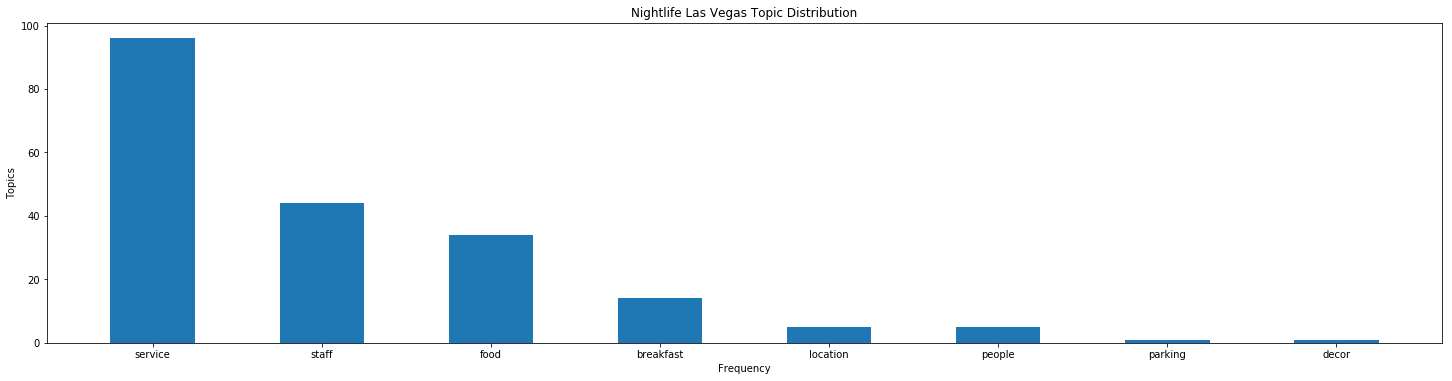

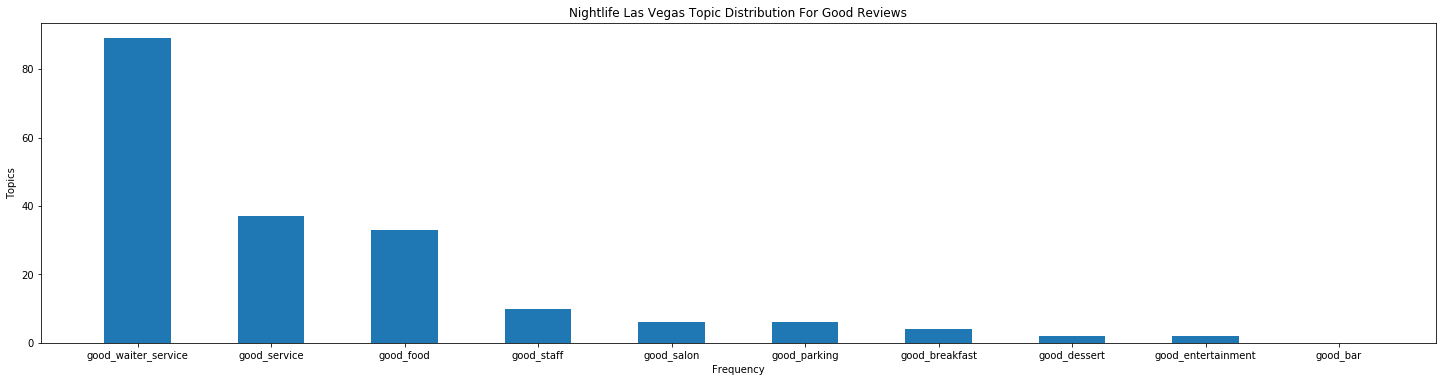

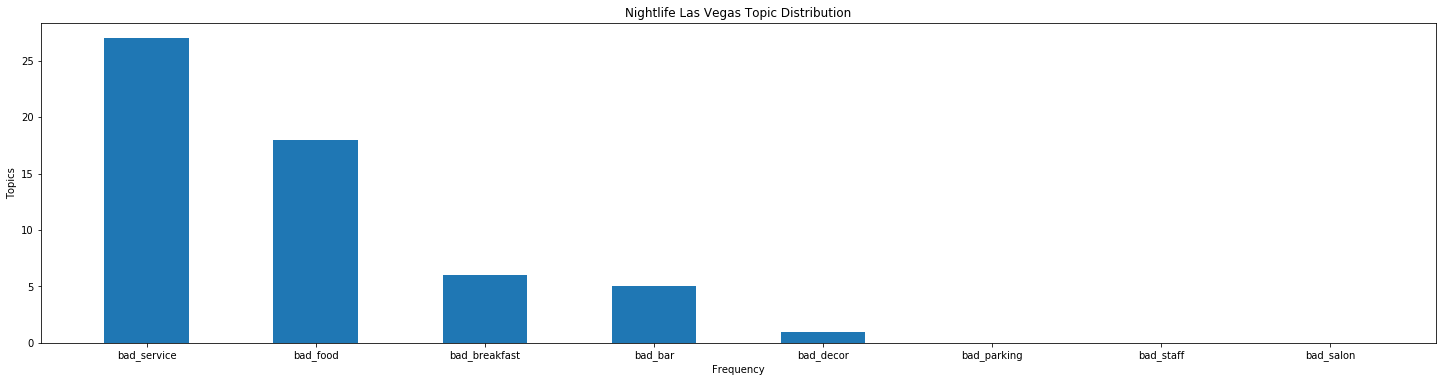

In [136]:
get_topic_distribution(restaurants, 'Nightlife', 'Las Vegas')

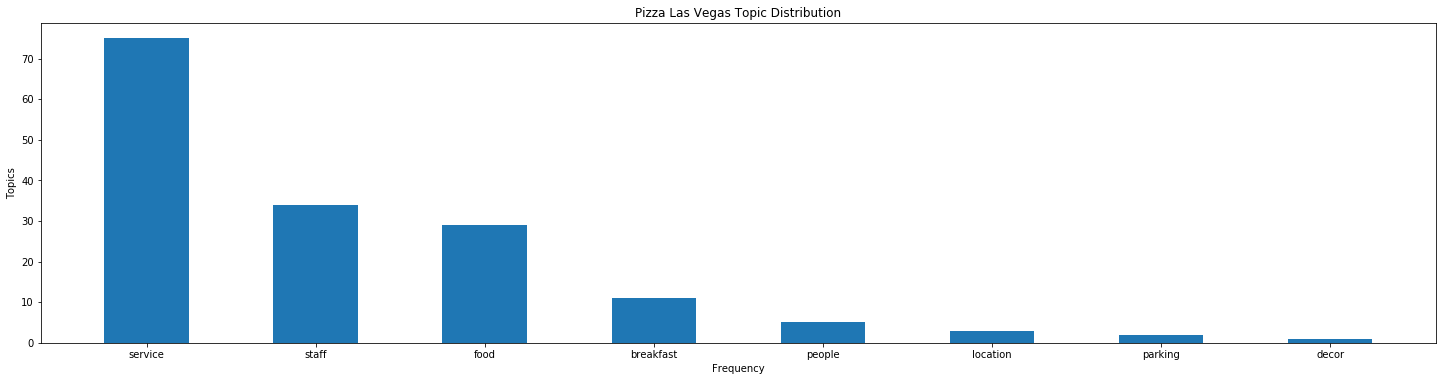

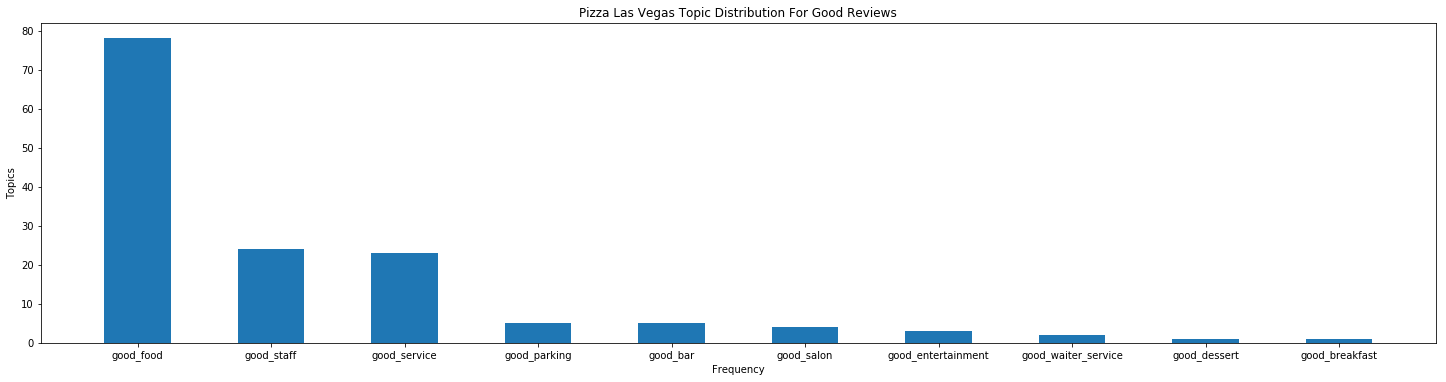

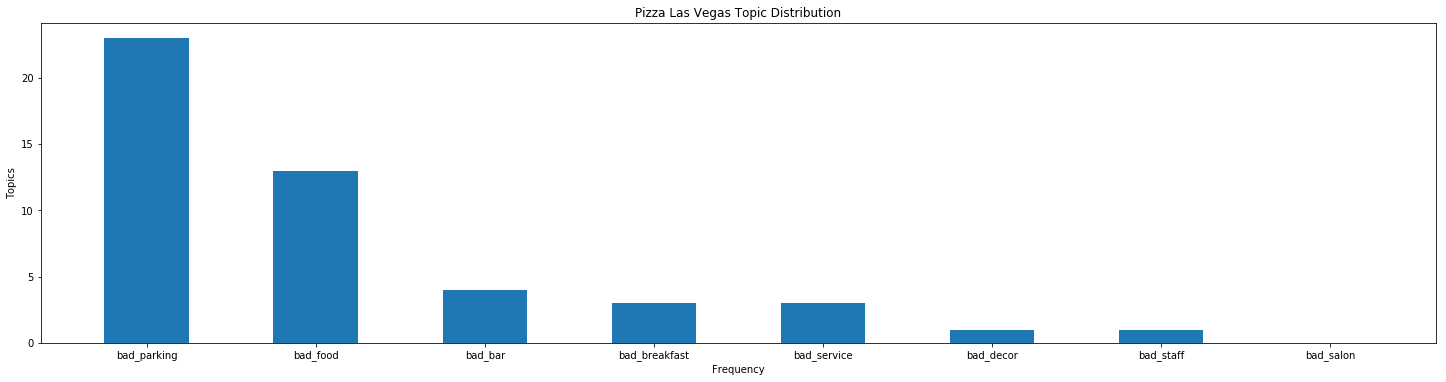

In [137]:
get_topic_distribution(restaurants, 'Pizza', 'Las Vegas')

In [19]:
pd.options.display.max_colwidth = 100 
temp = joined['categories'].str.contains('Restaurants', regex=False)
temp = temp.fillna(False)
temp = joined[temp]
#print(temp['categories'])
temp['categories'].value_counts()

Restaurants, Pizza                                                                                                                                1042
Pizza, Restaurants                                                                                                                                 993
Mexican, Restaurants                                                                                                                               885
Restaurants, Mexican                                                                                                                               853
Chinese, Restaurants                                                                                                                               840
Restaurants, Chinese                                                                                                                               789
Restaurants, Italian                                                                          

In [20]:
temp['city'].value_counts()

Toronto                          7964
Las Vegas                        6450
Phoenix                          3999
Montréal                         3784
Calgary                          2912
Charlotte                        2710
Pittsburgh                       2453
Scottsdale                       1573
Cleveland                        1495
Mississauga                      1447
Mesa                             1167
Madison                          1128
Tempe                            1044
Henderson                         885
Chandler                          866
Markham                           845
Glendale                          720
Gilbert                           577
Brampton                          546
Scarborough                       514
Richmond Hill                     503
Vaughan                           474
North York                        461
Champaign                         425
Peoria                            365
North Las Vegas                   351
Concord     